### 0. 초기 설정
- drive mount
- import modules
- gpu 연결
- 데이터 폴더 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DA28_pj03_3')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Colab Notebooks/DA28_pj03_3']

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets 
from torchvision import transforms 
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
from copy import deepcopy
import numpy as np

from NN_setting import setting
# from NN_model import print_models
from NN_train import train

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
!pip install kaggle
from google.colab import files
files.upload() 

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip -d cat_and_dog/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 96% 210M/218M [00:01<00:00, 198MB/s]
100% 218M/218M [00:01<00:00, 174MB/s]


### 1. 데이터 전처리
- train, valid, test 나누기
- label= 0: cat / 1: dog

In [7]:
mydata = setting()

In [8]:
getdata = datasets.ImageFolder
dir = './cat_and_dog/'
dircts = ['training_set/training_set','test_set/test_set']
transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])
mydata.getDataset(getdata, dir, dircts, transform)

trainset length: 8005 / testset length 2023


In [9]:
mydata.getValid(valid_s=0.2)

train length: 6404 / valid length: 1601
torch.Size([3, 224, 224]) 0


In [10]:
batch_s = 16
trainloader, validloader, testloader = mydata.getDataloader(batch_s)

train, valid, test: 401 101 127


### 2. 시각화

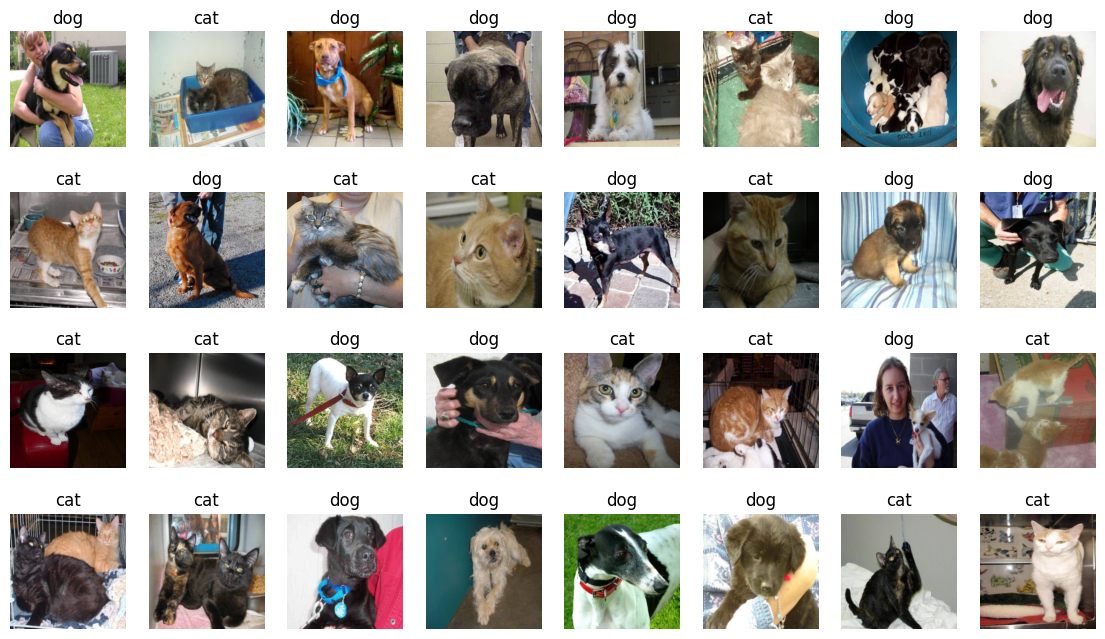

In [11]:
labels_map = {0 : 'cat', 1 : 'dog'}
mydata.showimg(labels_map, mydata.trainset)

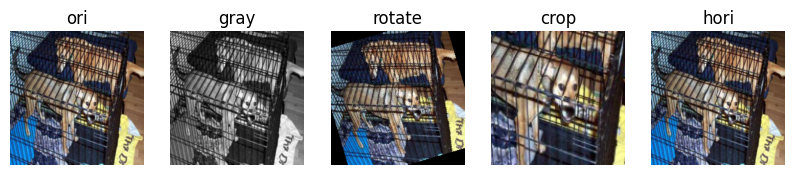

In [12]:
train_iter = iter(trainloader)
imgs, labels = next(train_iter)
sample_img = imgs[1]
mydata.showtransimg(sample_img)

### 3. model 설정

In [13]:
# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models
model = models.resnet101(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False 

model # find last classifier block name

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 231MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [15]:
model.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512,2))
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=2, bias=True)
)

### 4. 학습하기

In [16]:
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=lr) # optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN = train(model, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)

In [15]:
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=lr) # optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN = train(model, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()

Epoch : 1/55....... Train Loss : 0.091 Valid Loss : 0.041 Valid Accuracy : 0.976
Epoch : 2/55....... Train Loss : 0.066 Valid Loss : 0.036 Valid Accuracy : 0.976
Epoch : 3/55....... Train Loss : 0.059 Valid Loss : 0.050 Valid Accuracy : 0.973
Epoch : 4/55....... Train Loss : 0.061 Valid Loss : 0.039 Valid Accuracy : 0.977
Epoch : 5/55....... Train Loss : 0.038 Valid Loss : 0.050 Valid Accuracy : 0.970
Epoch : 6/55....... Train Loss : 0.031 Valid Loss : 0.047 Valid Accuracy : 0.973
Epoch : 7/55....... Train Loss : 0.031 Valid Loss : 0.083 Valid Accuracy : 0.969
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch : 8/55....... Train Loss : 0.024 Valid Loss : 0.052 Valid Accuracy : 0.973
Epoch : 9/55....... Train Loss : 0.025 Valid Loss : 0.053 Valid Accuracy : 0.973
Epoch : 10/55....... Train Loss : 0.016 Valid Loss : 0.055 Valid Accuracy : 0.970

Early Stopping!! epoch/epochs: 9/55


In [ ]:
myNN.result_plot()

### 5. 결과 예측

In [17]:
# myNN.check(unsq=True, rnd_idx=10)
def check(unsq=True, rnd_idx=10):
    test_iter = iter(myNN.testloader)
    imgs, labels = next(test_iter)
    print(imgs.size(), labels.size())
    print(imgs[rnd_idx].shape, labels[rnd_idx])
    myNN.model.eval()
    with torch.no_grad():
        logit = myNN.model(imgs[rnd_idx].unsqueeze(0))

    pred = logit.max(dim=1)[1]
    print(pred==labels[rnd_idx])
check()

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(0)
tensor([False])


### 6. test data 적용

In [21]:
myNN.evaluate(valid=False)

(0.05901019752170436, 0.9803149606299213)

In [23]:
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)

test loss: 0.059
test accuracy: 0.980


### 7. 모델 저장

In [18]:
torch.save(model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)

test loss: 0.693
test accuracy: 0.510


In [ ]:
myNN.load_model(dirct='best_checkpoint.pth', model=model)